In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from PIL import Image
import numpy as np
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Practicing training simple neural networks using tensorflow on the Intel Image classification dataset. There are 6 classes and over 14000 images. We will also test this model with non data-set images

In [2]:
TRAIN_DIR = '/kaggle/input/intel-image-classification/seg_train/seg_train'
TEST_DIR = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_DIR,
  seed=123,
  image_size=(150, 150),
  batch_size=64,
  label_mode = 'categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TEST_DIR,
  seed=123,
  image_size=(150, 150),
  batch_size=64,
  label_mode = 'categorical')

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [4]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## batch size is actually 16 not 9

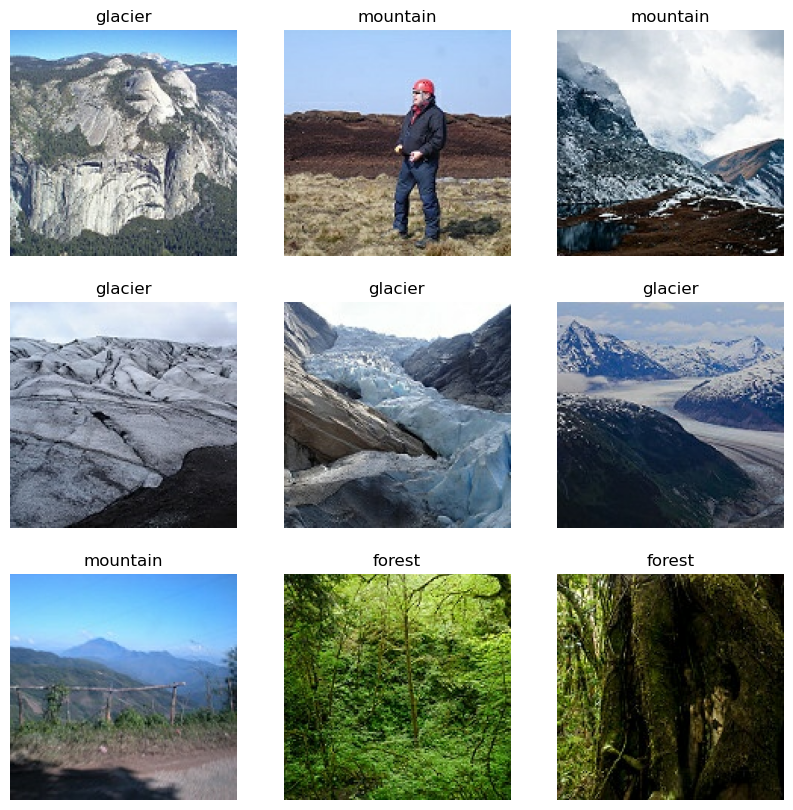

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# CNN from scratch

In [7]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 8, epochs = 10)

Epoch 1/10
8/8 [==============================] - 58s 3s/step - loss: 1.8526 - accuracy: 0.2090 - val_loss: 1.7459 - val_accuracy: 0.2633
Epoch 2/10
8/8 [==============================] - 21s 3s/step - loss: 1.6267 - accuracy: 0.3320 - val_loss: 1.4197 - val_accuracy: 0.4537
Epoch 3/10
8/8 [==============================] - 21s 3s/step - loss: 1.3363 - accuracy: 0.4746 - val_loss: 1.4451 - val_accuracy: 0.4167
Epoch 4/10
8/8 [==============================] - 21s 3s/step - loss: 1.2324 - accuracy: 0.5273 - val_loss: 1.2342 - val_accuracy: 0.5107
Epoch 5/10
8/8 [==============================] - 21s 3s/step - loss: 1.1816 - accuracy: 0.5469 - val_loss: 1.1388 - val_accuracy: 0.5523
Epoch 6/10
8/8 [==============================] - 21s 3s/step - loss: 1.1660 - accuracy: 0.5176 - val_loss: 1.1073 - val_accuracy: 0.5530
Epoch 7/10
8/8 [==============================] - 21s 3s/step - loss: 1.1439 - accuracy: 0.5781 - val_loss: 1.0793 - val_accuracy: 0.5573
Epoch 8/10
8/8 [==================

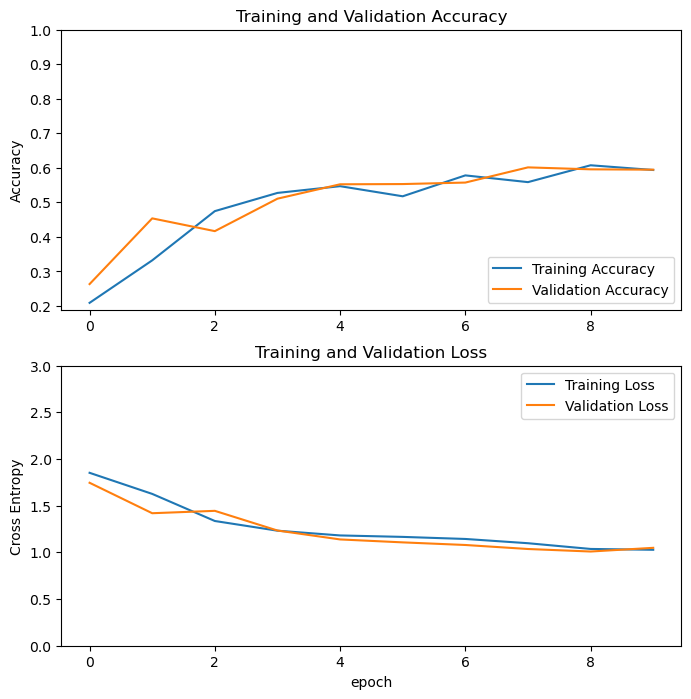

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

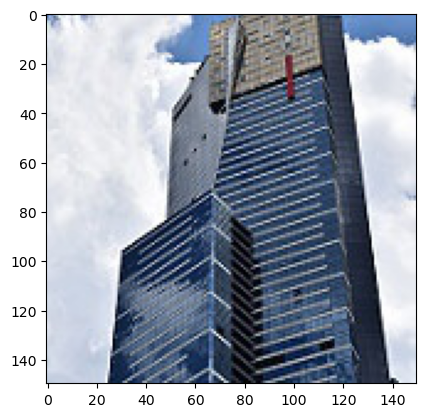

In [10]:
img = tf.keras.utils.load_img('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(img)


In [11]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 161ms/step
This image most likely belongs to buildings with a 79.886 percent confidence.


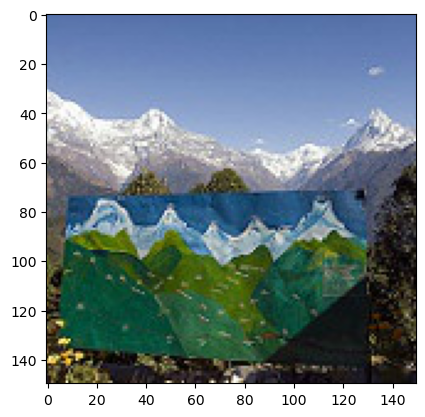

In [12]:
img = tf.keras.utils.load_img('/kaggle/input/intel-image-classification/seg_test/seg_test/mountain/20071.jpg')
plt.imshow(img)

In [13]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to mountain with a 65.138 percent confidence.


# Using Pre-Trained Model

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(150, 150, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 [==============================] - 3s 0us/step


In [15]:
history3 = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 10)

Epoch 1/10
10/10 [==============================] - 84s 9s/step - loss: 1.0501 - accuracy: 0.6766 - val_loss: 1.8676 - val_accuracy: 0.7853
Epoch 2/10
10/10 [==============================] - 95s 10s/step - loss: 0.5859 - accuracy: 0.7891 - val_loss: 0.8740 - val_accuracy: 0.8430
Epoch 3/10
10/10 [==============================] - 77s 8s/step - loss: 0.5456 - accuracy: 0.8266 - val_loss: 0.6966 - val_accuracy: 0.8557
Epoch 4/10
10/10 [==============================] - 78s 9s/step - loss: 0.4666 - accuracy: 0.8516 - val_loss: 0.4956 - val_accuracy: 0.8657
Epoch 5/10
10/10 [==============================] - 77s 8s/step - loss: 0.4880 - accuracy: 0.8156 - val_loss: 0.4671 - val_accuracy: 0.8720
Epoch 6/10
10/10 [==============================] - 96s 11s/step - loss: 0.4357 - accuracy: 0.8578 - val_loss: 0.4250 - val_accuracy: 0.8807
Epoch 7/10
10/10 [==============================] - 96s 11s/step - loss: 0.5234 - accuracy: 0.8297 - val_loss: 0.4152 - val_accuracy: 0.8790
Epoch 8/10
10/10 

In [16]:
print("Model accuracy: " + str(round(history3.history['val_accuracy'][9],4)) + "  and loss:  " +  str(round(history3.history['val_loss'][9],4)))

Model accuracy: 0.8873  and loss:  0.3359


# as you can see this model performs MUCH better

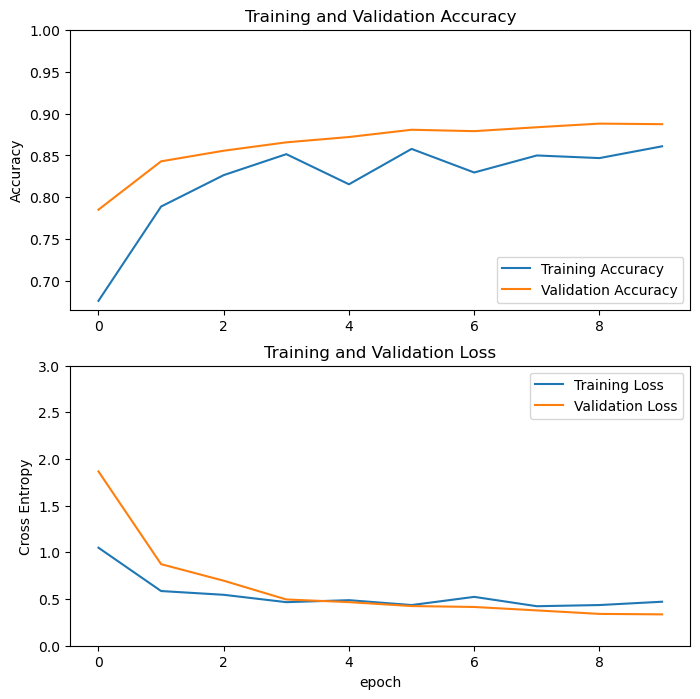

In [17]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

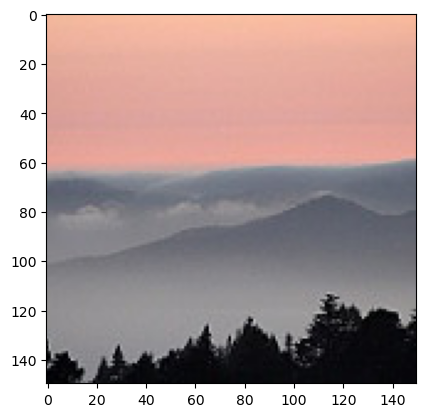

In [18]:
img = tf.keras.utils.load_img('/kaggle/input/intel-image-classification/seg_pred/seg_pred/10047.jpg')
plt.imshow(img) 

In [19]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to mountain with a 29.492 percent confidence.


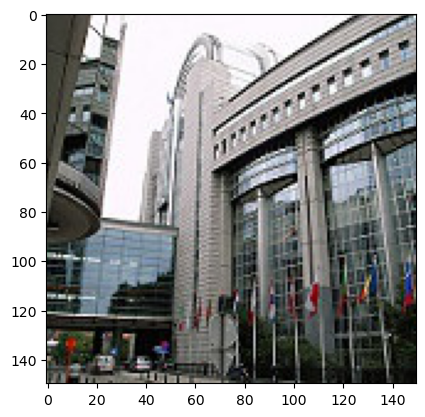

In [20]:
img = tf.keras.utils.load_img('/kaggle/input/intel-image-classification/seg_pred/seg_pred/10090.jpg')
plt.imshow(img) 

In [21]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 72ms/step
This image most likely belongs to buildings with a 28.799 percent confidence.


In [22]:
print(score)

tf.Tensor([0.28798693 0.13502671 0.13500881 0.13500468 0.13501915 0.17195371], shape=(6,), dtype=float32)


# THANK YOU FOR READING